## Natural Language Processing: Twitter Sentiment Analysis

.
###### April 13 2018
.

Twitter is an online social network with over 330 million active monthly users as of February 2018. Users on twitter create short messages called tweets to be shared with other twitter users who interact by sharing (retweeting) and / or responding. Twitter employs a message size restriction of 280 characters or less which forces the users to stay focused on the message they wish to disseminate. This very characteristic makes messages from twitter a good candidate for Natural Language Processing (NLP) machine learning tasks like sentiment analysis.


#### Paul Ryan won't run for re-election!

While sentiment analysis on twitter data has been [performed many times,](https://scholar.google.com/scholar?q=arxiv+twitter+sentiment+analysis&hl=en&as_sdt=0&as_vis=1&oi=scholart&sa=X&ved=0ahUKEwiZqKbR7avaAhVEKKwKHYZCDlYQgQMIJjAA) building experience and tackling bigger challenges always builds on a form of prevoius work from others. In this project, I attempt to use a Naive Bayes Classifier to extract sentiment analysis from tweets captured on twitter on April 12th of 2018 for the keyword ["Paul Ryan"](https://en.wikipedia.org/wiki/Paul_Ryan). The tweets are from the day after the current ***Speaker of the United States House of Representatives*** in the ***US Congress***  a day after the Republican polititian announced that he would not be running for re-election in the next elections. This topic is especially interesting because of the current polarized state in the national political arena with the Republicans controlling both houses in congress as well as the exceutive branch through President Trump.

As expected, the country took to twitter to voice their opinions as twitter users usually do and I thought it would be a prime moment to explore the general sentiment of the country towards this political announcement.

.   image credit: [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Speaker_Paul_Ryan_official_photo.jpg)
![Wiki  Commons Media](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Speaker_Paul_Ryan_official_photo.jpg/750px-Speaker_Paul_Ryan_official_photo.jpg) 

.

I downloaded the data using twitter's api which has some limitations about how many requests you can make and how far back but the idea of using this data came to me during the same time the as the news release so I was able to capture a good bit of it. For non paying developer access, twitter also limits the percentage of data available per keyword search to well below 20%. Full documentaion and terms of the API are avilable at [developer.twitter.com/en/docs](https://developer.twitter.com/en/docs)

I used a Naive Bayes Classifier (NB) to learn the correct labels from the training data. I used training dataset from [Sentiment140](http://help.sentiment140.com/) at sentiment140.com. The dataset comes with prelabeled columns containing one of two binary targets. Zero(0) for Negative sentiment and One(1) for Positive sentiment. The data is made up of about 1.6 million random tweets with corresponding sentiment labels.

<a id='back_to_the_top_cell'></a>

### This notebook is broken down into different section as follows:

You can click on the section description to skip to that section directly.
- Section 1: [Training Dataset Exploration](#import_first_data_cell)
- Section 2: [Test Data - Twitter Data Exploration](#twitter_data) - this data will be used on trained model for sentiment extraction
- Section 3: [Text Pre-Processing for Sentiment Analysis](#preprocessing_section) - a step by step walk through
- Section 4: [Model Training and Evaluation](#first_model_train)
- Section 5: [Geoplots, Final Thoughts and Conclusions](#conclusions)

 Import the necessary libraries

In [17]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
from wordcloud import WordCloud

import plotly
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime

pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-white')

[back to the top](#back_to_the_top_cell)

<a id='import_first_data_cell'></a>

### Section 1: Explore Training Dataset

Import the data to a pandas dataframe and do some exploratory data analysis for a deeper understanding of the dataset.


In [23]:
# load train data
data = pd.read_csv('Sentiment Analysis Dataset.csv',
                   error_bad_lines=False)
data.columns = ['id','label','source','text']
data.head(2)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


id  label        source  \
0  1   0      Sentiment140   
1  2   0      Sentiment140   

                                                            text  
0                       is so sad for my APL friend.............  
1                     I missed the New Moon trailer...

In [24]:
# get text and matching label columns
data = data.drop(['id','source'],axis=1)
data.head(10)

label  \
0  0       
1  0       
2  1       
3  0       
4  0       
5  0       
6  1       
7  0       
8  1       
9  1       

                                                                                                                                   text  
0                       is so sad for my APL friend.............                                                                         
1                     I missed the New Moon trailer...                                                                                   
2                omg its already 7:30 :O                                                                                                 
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...  
4           i think mi bf is cheating on me!!!       T_T                                                                                 
5           or i just worry too much?                                                                                                    
6         Juuuuuuuuuuuuuuuuussssst Chillin!!                                                                                             
7         Sunny Again        Work Tomorrow  :-|       TV Tonight                                                                         
8        handed in my uniform today . i miss you already                                                                                 
9        hmmmm.... i wonder how she my number @-)

- We can observe that the data is indeed about tweet messages posted on twitter.
- The labels and the text do not seem to be in any listed order. This can be a problem if data is not randomly distributed as it can introduce biases to a learning model. In any case, we are going to use the [Scikit Learn](http://scikit-learn.org/stable/documentation.html) library which has a function to split our training and testing data and shuffles the data at the same time. 
- Shuffling data reduces variance and makes sure our model can generalize better on the data and does less overfitting. We want to make sure the train and test dataset are representative of the overal distribution of the data.
- To that note, we also want to check the label distribution in the data which is done below.
- Another observation we can make is that the text contains varying formats like some words with upper cases which need to be normalized to their base word. Leaving capitalized word unchanged if they appear in the middle of a sentence can be experimented with as they may hold a different feature space like the name of a person or country etc.

In [26]:
# check the number of positive vs. negative tagged sentences
positives = data['label'][data.label == 0]
negatives = data['label'][data.label == 1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of positve tagged sentences is:  788435
number of negative tagged sentences is: 790177
total length of the data is:            1578612


In [27]:
# get unique label counts
data.groupby('label').describe()

text                                                      
        count  unique                                      top freq
label                                                              
0      788435  788435  @Dreamer1010 don't forget about meeee!   1  
1      790177  790177  Off to see Star Trek. So excited         1

- Considering the size of the dataset, the labels seem to be 'about' evenly distributed at 788435 vs. 790177 for positive and negative respectively.
- Next, we want to see the number of words contained in every sentence so I created a function to extract this information and appended it to a column next to the text column.

In [28]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['text'].apply(word_count)
data.head(3)

label                                                           text  \
0  0                           is so sad for my APL friend.............   
1  0                         I missed the New Moon trailer...             
2  1                    omg its already 7:30 :O                           

   word count  
0  7           
1  6           
2  5

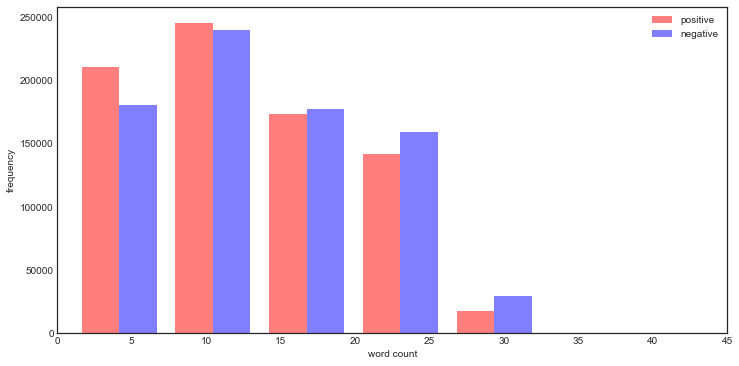

In [31]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.label == 1]
y = data['word count'][data.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

- From the graph above, most sentences fall between 5-10 words but it's fair to say that majority of text on twitter falls between 1 and 25 words. This is no wonder considering that twitter has a limit of how many characters one can use in a message. 280 characters is the limit at the time of this writing.
- In all, it looks like 1-20 words covers more than 80% of all sentences which makes this dataset set a good training candidate for our twitter data which is also restricted to 280 characters.
- There are a more positive sentences with 5 words or less than there are negative ones which is does not seem like a big enough difference to cause any concern at the moment.

In [32]:
# get most common words in training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 741876),
 ('to', 556149),
 ('the', 516654),
 ('a', 374024),
 ('my', 309966),
 ('and', 294805),
 ('you', 236109),
 ('is', 229444),
 ('for', 212852),
 ('in', 209009)]

- In the cell above we extract the most common words in the dataset and list the top ten.
- Perhaps to no surprise we encounter words like **i, and** and **is** as they are very highly used in human expressions. These kind of words usually appear equally in both negative and positive oriented expressions and as such they bring very little information that can be incorporated in the model so we will have to get rid of them down the road.
- In the text preprocessing steps later on we will learn how to deal with these common words that don't add much to the feature space.
- Below is a graph showing the frequency of the first 25 words.

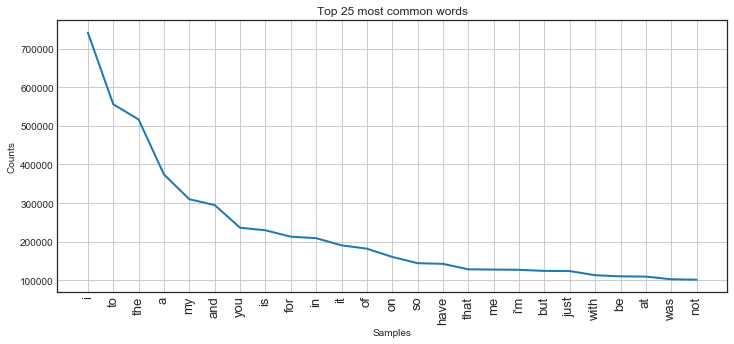

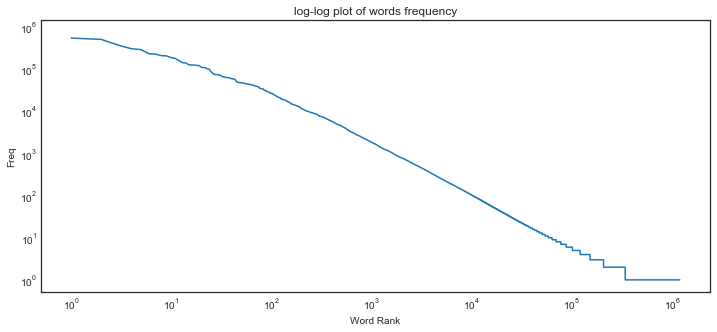

In [33]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

- I also created a [**log-log**](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot)  plot for the words frequency which is similar to the previous frequency graph but includes all words and is plotted on a base 10 logarithimic scale which helps us visualize the rapidly diminishing frequency of words as their rank drops.
- The word distribution present in this data dictionary is a very common phenomenon in large samples of words as shown by [Zipf's law](https://simple.wikipedia.org/wiki/Zipf%27s_law) where  the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, etc. 
- It would be intersting to see if this holds true after we remove words like **i, and** and **is** from the observation above.

[back to the top](#back_to_the_top_cell)

<a id='twitter_data'></a>


### Section 2: Twitter Data For Sentiment Analysis
#### Download Twitter data through API

- After training the model we make sentiment preditions on the twitter data but before we can do that, we need to download and do some basic data cleaning.
- I used [tweepy](http://tweepy.readthedocs.io/en/v3.6.0/) which is a python wrapper library for the twitter api that gives you more control on how you query the api.
- To get a good chunk of data for the test dataset, I downloaded data using the key words'paul' AND 'ryan'through the api search function.
- Detailed instuctions on how to search and dowload data from twitter are available on [tweepy.readthedocs.io](http://tweepy.readthedocs.io/en/v3.6.0/).
- Below is some code I used to get the twitter data.

In [169]:
# twitter api credentials - you need these to gain access to API
consumer_key = '**************************'
consumer_secret = '**************************'
access_token = '**************************'
access_token_secret = '**************************'

# instantiate the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [171]:
# string to search on twitter
query = 'paul AND ryan'

# open/create a csv file to append data
csvFile = open(query + '_data2.csv', 'w', encoding='utf-8')

# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tweepy.Cursor(api.search,q=query+ ' -RT',count=10000000,lang="en").items(100):
    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass

tweet number: 0 The worst take imaginable. Paul Ryan regularly beat the drum of deficit reduction and claimed tax cuts would genera… https://t.co/qfRWlRLUpo Swissvale, PA
tweet number: 1 @jonallendc Additionally, Paul Ryan consistently lied about what the after effects would be knowing the data/math d… https://t.co/NJJlt38YUb Florida, USA
tweet number: 2 @SenBobCasey Someone talk to that tool Paul Ryan and that ugly disgusting McConnell and let them get their leader in order Williamsville, NY
tweet number: 3 Ryan, Republicans and the Republic https://t.co/EnsbPhFYVz Brookline, MA
tweet number: 4 @SpeakerRyan Paul Ryan, who proposed raising the retirement age to 70, announced his retirement at 48—with full GOVERNMENT PENSION Dewey, AZ
tweet number: 5 Watching the #lovettorleaveit Chicago panel (let’s be truthful mostly @jonlovett) get Malört-faced was like going o… https://t.co/rNbUHDYeM5 The Chicago Theatre


#### Build a working dataframe and visualize data and do some data cleaning

In [71]:
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_twtr = pd.read_csv('paul_ryan_twitter.csv', names=col_names)

# check head
df_twtr.head()

date           user_loc  followers  friends  \
0  2018-04-13 08:14:22  NaN                61         367       
1  2018-04-13 08:01:58  Long Island, NY    3656       3549      
2  2018-04-13 07:48:16  Alameda Ca         2304       2917      
3  2018-04-13 07:45:37  San Francisco, CA  52         876       
4  2018-04-13 07:30:20  Greenville, SC     833        4367      

                                                                                                                                        message  \
0  This is Paul Ryan. Exactly. 100%. Fuck Paul Ryan. https://t.co/MYxN9jOas8                                                                      
1  There's a video from the Daily Show (Comedy Central) you'll want to see.\r\nhttps://t.co/wjKUW9wBXo                                            
2  @SallyAlbright First of all, discrediting the FBI is disgusting and borderline treasonous.  Secondly, I wonder if t… https://t.co/BdnZrBCKhq   
3  Paul Ryan is a coward and a piece of shit! Good riddance! Now if the rest of the pieces of shit in that party would… https://t.co/kRCeUl3zej   
4  @robreiner Paul Ryan realized he could not forever serve 2 gods-- that dual self-serving gospels would inevitably c… https://t.co/jaTMhFHDnR   

                                                                                                        bbox_coords  \
0  [[[-74.988897, 39.810025], [-74.908642, 39.810025], [-74.908642, 39.87514], [-74.988897, 39.87514]]]               
1  [[[-79.76259, 40.477383], [-71.777492, 40.477383], [-71.777492, 45.015851], [-79.76259, 45.015851]]]               
2  [[[-122.332411, 37.720367], [-122.224562, 37.720367], [-122.224562, 37.797229], [-122.332411, 37.797229]]]         
3  [[[-121.6919801, 36.643802], [-121.5905572, 36.643802], [-121.5905572, 36.7344965], [-121.6919801, 36.7344965]]]   
4  [[[-82.465548, 34.708643], [-82.418761, 34.708643], [-82.418761, 34.751491], [-82.465548, 34.751491]]]             

          full_name        country country_code place_type  
0  Voorhees, NJ      United States  US           city       
1  New York, USA     United States  US           admin      
2  Alameda, CA       United States  US           city       
3  Salinas, CA       United States  US           city       
4  Golden Grove, SC  United States  US           city

In [72]:
# Sort dataframe by date column
df_twtr['date'] = pd.to_datetime(df_twtr['date'])
df_twtr = df_twtr.sort_values(by='date',ascending=True)
df_twtr = df_twtr.reset_index().drop('index',axis=1)
df_twtr.head()

date         user_loc  followers  friends  \
0 2018-04-09 23:52:02  London, England  93         382       
1 2018-04-09 23:56:39  NaN              4          1         
2 2018-04-09 23:57:41  Florida, USA     22         37        
3 2018-04-10 00:00:04  New York City    1454       3053      
4 2018-04-10 00:03:42  Miami, FL        4          35        

                                                                                         message  \
0  We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.   
1  PAUL RYAN AND MITCH McCONNELL ARE  BIG SISSIES!!!                                               
2  Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS         
3  @RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?              
4  @kylegriffin1 where are Paul Ryan or mitch mcconnell ???                                        

                                                                                                bbox_coords  \
0  [[[-0.259465, 51.417277], [-0.127974, 51.417277], [-0.127974, 51.486036], [-0.259465, 51.486036]]]         
1  [[[-80.519851, 39.719801], [-74.689517, 39.719801], [-74.689517, 42.516072], [-80.519851, 42.516072]]]     
2  [[[-80.173447, 26.476484], [-80.05236, 26.476484], [-80.05236, 26.5904875], [-80.173447, 26.5904875]]]     
3  [[[-74.026675, 40.683935], [-73.910408, 40.683935], [-73.910408, 40.877483], [-74.026675, 40.877483]]]     
4  [[[-80.321683, 25.7090404], [-80.144974, 25.7090404], [-80.144974, 25.855667], [-80.321683, 25.855667]]]   

            full_name         country country_code place_type  
0  Wandsworth, London  United Kingdom  GB           city       
1  Pennsylvania, USA   United States   US           admin      
2  Boynton Beach, FL   United States   US           city       
3  Manhattan, NY       United States   US           city       
4  Miami, FL           United States   US           city

In [73]:
# get central geo location from the bounding box for later mapping

# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# ____________________________________________________________

# append new column  and clean up df
df_twtr['geo_code'] = df_twtr['bbox_coords'].apply(geo_mean)
df_twtr = df_twtr.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_twtr.head()


date         user_loc  \
0 2018-04-09 23:52:02  London, England   
1 2018-04-09 23:56:39  NaN               
2 2018-04-09 23:57:41  Florida, USA      
3 2018-04-10 00:00:04  New York City     
4 2018-04-10 00:03:42  Miami, FL         

                                                                                         message  \
0  We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.   
1  PAUL RYAN AND MITCH McCONNELL ARE  BIG SISSIES!!!                                               
2  Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS         
3  @RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?              
4  @kylegriffin1 where are Paul Ryan or mitch mcconnell ???                                        

            full_name         country country_code                 geo_code  
0  Wandsworth, London  United Kingdom  GB           [-0.19372, 51.451656]    
1  Pennsylvania, USA   United States   US           [-77.604684, 41.117936]  
2  Boynton Beach, FL   United States   US           [-80.112903, 26.533486]  
3  Manhattan, NY       United States   US           [-73.968542, 40.780709]  
4  Miami, FL           United States   US           [-80.233328, 25.782354]

In [ ]:
df_twtr.to_pickle('df_paulry.p') # save dframe to pickle

In [74]:
df_paulry = pd.read_pickle('df_paulry.p')  # load from pickle

[back to the top](#back_to_the_top_cell)

<a id='preprocessing_section'></a>


## Section 3: Text Pre-processing 

- Text pre-processing is important for the Natural Language Processing (NLP) task of sentiment extraction so as to remove any unnecesary characteristics in the data which would make the final trained model a poor generalizer. 
- Text pre-processing can involve many things like removing unwanted characters like emojis, properly formatting the text to remove extra spaces or any other information in the text that we don't believe would make a great feature for our model. We'll see some examples below.
- We also have to make sure that the information we pass the model is in a format that computers can understand. That is in digits not words. We'll also go through some of these steps below.
- After this pre-processing step, our data should be ready to be fed to the right machine learning (ML) algorithim to extract valuable information that it can use to do classification on unseen data.

   <span style="color:red">**NOTE**:</span>
    - Text pre-processing is done to the training data to facilitate the model's learning but for the text pre-processing examples below, I will use a copy of the twitter dataset since it is messier than our training data and as such there are more opportunities to demonstrate the text processing techniques.
        
    - Therefore the actual training of the model will take the original training data and coresponding labels during training.
    

#### Pre-processing 1: Clean tweet text by removing links, special characters
- This step is one that we could spend a lot of time on but the goal is always to find the best balance
- The  bulk of the work in NLP is done on feature engineering and this is one of the processes that could alter the features you end up with. 

- I created a funtion to do bulk formatting / clean up for every tweet in the dataset. The function is commented to show what every line is doing.

In [75]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_paulry['message'] = df_paulry['message'].apply(processTweet)
# preview some cleaned tweets
df_paulry['message'].head()

0    ’ look back today the first time paul ryan said “ ” without hint irony 
1    paul ryan and mitch mcconnell are big sissies                          
2    were are mcconell and paul ryan your silence sickening                 
3    over under paul ryan potus cinco impeacho                              
4    where are paul ryan mitch mcconnell                                    
Name: message, dtype: object

- A point to note here is how you cannot have a perfect set of clean up steps over all data as some steps will ultimately introduce some flaws in the data. 
- Below is an example where *'re'* has been removed from *re-election* which alters the meaning of the word and perhaps the users' sentiment towards it. The word *won't* also changes to *won* which obviously has a totally different meaning.

In [41]:
before = df_paulry['message'][600]
after = processTweet(before)

before,'\n',after

("House Speaker Paul Ryan won't seek re-election\r\n\r\nhttps://t.co/eAaOUAHIGY",
 '\n',
 'house speaker paul ryan won seek election ')

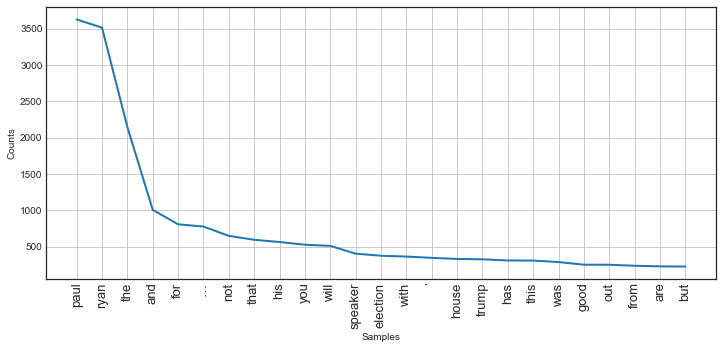

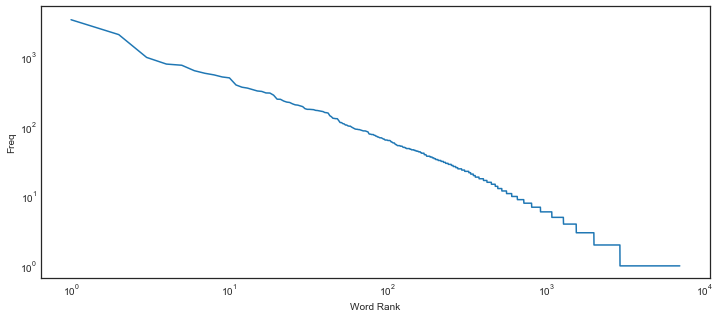

In [47]:
# most common words in twitter dataset
all_words = []
for line in list(df_paulry['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

.


- Drop duplicate tweets as they bring no new information to the dataset and are also computationally inefficient.


In [48]:
# drop duplicates
df_paulry = df_paulry.drop_duplicates('message')
df_paulry.shape

(3966, 7)

#### Pre-processing 2: Tokenize without out Stop-Words

- Our hypothetical training data has now been transformed into a much leaner body of text that is much cleaner for feature extraction. As we mentioned a few times before, we do have some words in the dataset that are common in natural human language but used in all sentiment expressions that we would be better off without them since they bring no useful features to our model.
- These words are commonly known as [stop-words](https://en.wikipedia.org/wiki/Stop_words) in NLP and the [NLTK library](http://text-processing.com/demo/sentiment/) comes with a dataset containing a long list of stop words that we are going to access and filter out of our dataset. Below is the actual words contained in the stop_words list. We can also make our own special case stop words to fit any unique case. For example if you are doing sentiment analysis on law documents, you would probably need a special set considering the jargon contained there in.

In [76]:
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)

("i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it ",
 179)

.
- After removing stop-words we split all the sentences in the dataset to get individual words **(tokens)** which is basically a list of words contained in the newly processed message.

In [85]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


def remove_words(word_list):
    remove = ['paul','ryan','...','“','”','’','…','ryan’']
    return [w for w in word_list if w not in remove]

# -------------------------------------------

# tokenize message column and create a column for tokens
df_paulry = df_paulry.copy()
df_paulry['tokens'] = df_paulry['message'].apply(text_process) # tokenize style 1
df_paulry['no_pauls'] = df_paulry['tokens'].apply(remove_words) #tokenize style 2
df_paulry.head()

date         user_loc  \
0 2018-04-09 23:52:02  London, England   
1 2018-04-09 23:56:39  NaN               
2 2018-04-09 23:57:41  Florida, USA      
3 2018-04-10 00:00:04  New York City     
4 2018-04-10 00:03:42  Miami, FL         

                                                                   message  \
0  ’ look back today the first time paul ryan said “ ” without hint irony    
1  paul ryan and mitch mcconnell are big sissies                             
2  were are mcconell and paul ryan your silence sickening                    
3  over under paul ryan potus cinco impeacho                                 
4  where are paul ryan mitch mcconnell                                       

            full_name         country country_code                 geo_code  \
0  Wandsworth, London  United Kingdom  GB           [-0.19372, 51.451656]     
1  Pennsylvania, USA   United States   US           [-77.604684, 41.117936]   
2  Boynton Beach, FL   United States   US           [-80.112903, 26.533486]   
3  Manhattan, NY       United States   US           [-73.968542, 40.780709]   
4  Miami, FL           United States   US           [-80.233328, 25.782354]   

                                                                              tokens  \
0  [’, look, back, today, first, time, paul, ryan, said, “, ”, without, hint, irony]   
1  [paul, ryan, mitch, mcconnell, big, sissies]                                        
2  [mcconell, paul, ryan, silence, sickening]                                          
3  [paul, ryan, potus, cinco, impeacho]                                                
4  [paul, ryan, mitch, mcconnell]                                                      

                                                       no_pauls  
0  [look, back, today, first, time, said, without, hint, irony]  
1  [mitch, mcconnell, big, sissies]                              
2  [mcconell, silence, sickening]                                
3  [potus, cinco, impeacho]                                      
4  [mitch, mcconnell]

In [54]:
# style 1 tokens
df_paulry['tokens'].head(10) 

0    [’, look, back, today, first, time, paul, ryan, said, “, ”, without, hint, irony]             
1    [paul, ryan, mitch, mcconnell, big, sissies]                                                  
2    [mcconell, paul, ryan, silence, sickening]                                                    
3    [paul, ryan, potus, cinco, impeacho]                                                          
4    [paul, ryan, mitch, mcconnell]                                                                
5    [think, chances, mitch, mcconnell, paul, ryan, grow, ball…]                                   
6    [time, time, state, look, demarcated, get, ready, vote, democrats, paul, ryan, bill, defeated]
7    [cbo, currently, headed, republican, voted, paul, ryan, gop, house, right…]                   
8    [sorry, damn, thing, paul, ryan, mitch, mcconnell, afraid, donald, trump, …]                  
9    [time, paul, ryan, take, hike]                                                                


In [98]:
# style 2 tokens
df_paulry['no_pauls'].head(10)

0    [look, back, today, first, time, said, without, hint, irony]                      
1    [mitch, mcconnell, big, sissies]                                                  
2    [mcconell, silence, sickening]                                                    
3    [potus, cinco, impeacho]                                                          
4    [mitch, mcconnell]                                                                
5    [think, chances, mitch, mcconnell, grow, ball…]                                   
6    [time, time, state, look, demarcated, get, ready, vote, democrats, bill, defeated]
7    [cbo, currently, headed, republican, voted, gop, house, right…]                   
8    [sorry, damn, thing, mitch, mcconnell, afraid, donald, trump]                     
9    [time, take, hike]                                                                
Name: no_pauls, dtype: object

- We can see now that we a have a new column in the dataframe that contains these token words.
- There are additional normalization techniques like **[stemming](http://www.nltk.org/howto/stem.html)** and **[lemmatizing](http://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)** that we can try on our data but twitter messages and words are short by design and the above may not work so well because they essentially shorten words to their base words.
- For now we will stick with the current normalized  state of our message data which we can now convert into a vector that can be fed into the appropriate ML algorithim. 
- I have also created a word cloud depicting the most common words in the entire twitter dataset after normalization.
- We can see our keywords - paul & ryan - are obiously very prominent but some domain knowledge would be helpful in making sense of why some of the words are there. It's twitter so you can expect the whole spectrum of emotions. I can tell you that there are words in the dataset that display very strong emotions feelings towards our search keywords.

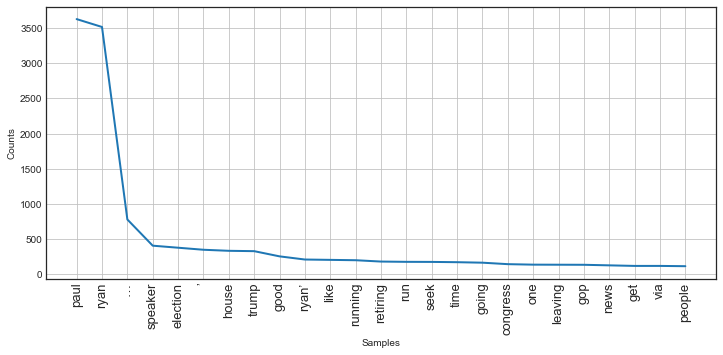

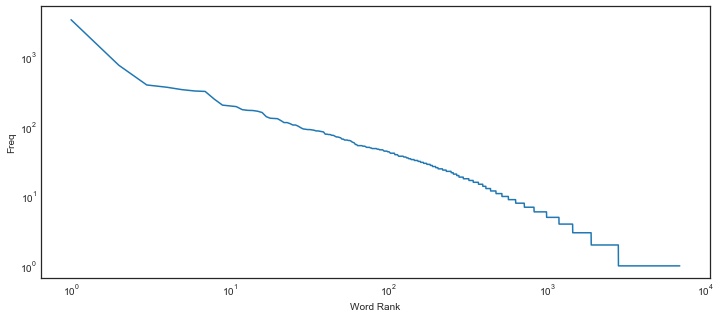

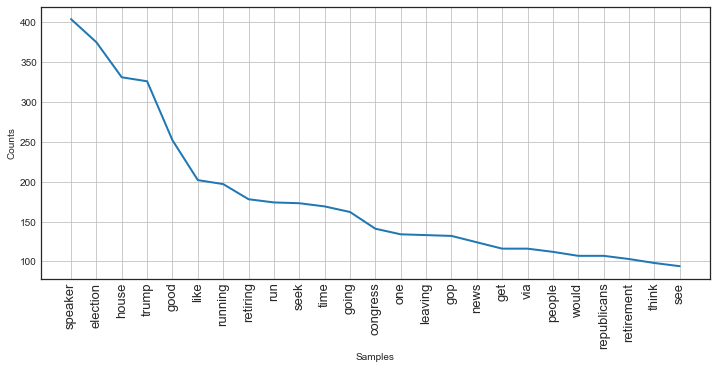

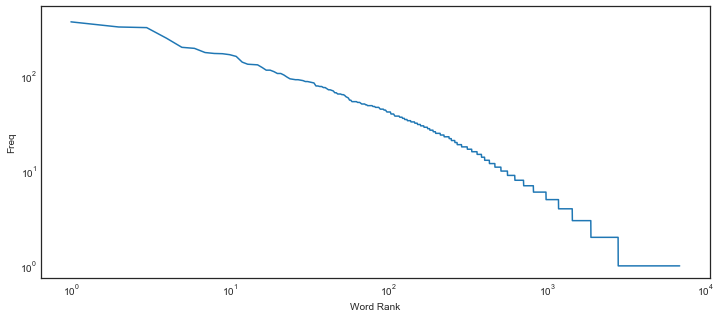

In [89]:
# most common words in twitter dataset
all_words = []
for ls in df_paulry['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

# plot word frequency distribution of first few words without paul, ryan
# no_pauls
no_pauls = []
for ls in df_paulry['no_pauls']:
    words = [w for w in ls]
    for word in words:
        no_pauls.append(word)
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(no_pauls)
fd.plot(25,cumulative=False)

# log-log  of all words -- no_pauls 
word_counts = sorted(Counter(no_pauls).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

- The word cloud also excludes the words *paul* and *ryan* as they disproportionately common in the dataset.

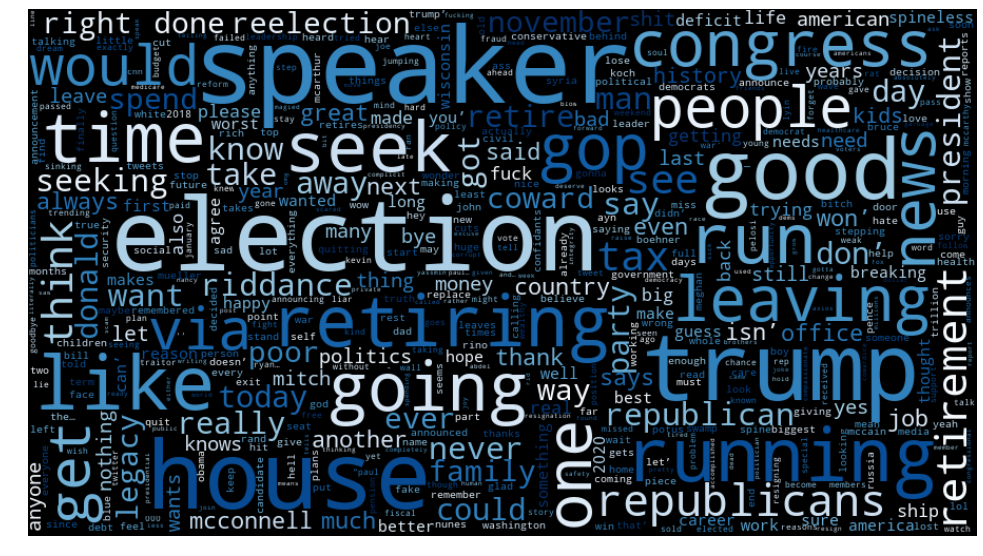

In [93]:
# split sentences to get individual words
all_words = []
for line in df_paulry['no_pauls']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Pre-processing 3:  Feature Extraction

#### Vectorization - (Bag Of Words)

- We'll convert each message which is represented by a list of tokens into a vector that a machine learning model can understand.
- To do this we use the [Bag Of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) model which is a three step process.
    
    1.Count how many times does a word occur in each message (Known as term frequency)

    2.Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

    3.Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

- Each vector will have as many dimensions as there are unique words in the tweeter corpus.
- We will first use SciKit Learn's CountVectorizer funtion which converts a collection of text documents to a matrix of token counts.
- Imagine this as a 2-D matrix where 1-D is the entire vocabulary contained in the meassages and the other dimension is one column per tweet.
- Since there are so many messages, we can expect a lot of zero counts for the presence of every word in the data but SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [94]:
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_paulry['message'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

6865


In [37]:
# uncomment to view the entire word vocabulary 
# bow_transformer.vocabulary_

In [96]:
# example of vectorized text
sample_tweet = df_paulry['message'][111]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

president paul ryan here come 


  (0, 1148)	1
  (0, 4138)	1
  (0, 4406)	1
  (0, 5057)	1




In [97]:
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df_paulry['message'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (4164, 6865)
Amount of Non-Zero occurences:  37931


#### Term Frequency, Inverse Document Frequency

- TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.
- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
- One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

- Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

- TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

- IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

- See below for a simple example.

        Example:

        Consider a document containing 100 words wherein the word cat appears 3 times.

        The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents
        and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is 
        calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities:
        0.03 * 4 = 0.12.

In [100]:
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 5057)	0.154157821674
  (0, 4406)	0.632873815331
  (0, 4138)	0.148665838145
  (0, 1148)	0.744046079523


- We'll go ahead and check what is the IDF (inverse document frequency) of the word "pogba" and of word "liverpool"?

In [101]:
# some IDF (inverse document frequency) example
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['trump']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['gop']])

3.59146836679
4.47465915024


- To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [102]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4164, 6865)


- After preprocessing the data, we are now ready to pass it through a ML classification algorithim. 
- That ends the text pre-processing stages of our workflow but we will revist this steps as one *pipeline* step in the section below.

[back to the top](#back_to_the_top_cell)

<a id='first_model_train'></a>

### Section 4: First Model Training and Evaluation

#### Naive Bayes Classifier

In this classification task we are going to use a **Naive Bayes (NB)** classifier which is based on the [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). In a nutshell, the NB classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.  So for example, a fruit may be considered to be an apple if it is red, round, and about 3″ in diameter. A Naive Bayes classifier considers each of these “features” (red, round, 3” in diameter) to contribute independently to the probability that the fruit is an apple, regardless of any correlations between features. Features, however, aren’t always independent which is often seen as a shortcoming of the Naive Bayes algorithm and this is why it’s labeled “naive”. However it is relatively simple to understand, build and train and mostly very fast all which makes it a good candidate for sentiment classification.

    - Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c). 
    Look at the equation below:

![alt text](naive_bayes_rule.png) 



    - P(c|x) is the posterior probability of class (c, target) given predictor (x, attributes).
    - P(c) is the prior probability of class.
    - P(x|c) is the likelihood which is the probability of predictor given class.
    - P(x) is the prior probability of predictor.

#### Create Pipeline to manage the above preprocessing steps in one step


- SciKit Learn provides a [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capability that lets you define a pipeline workflow which will take all the above steps and even a classifier and grid search parameters. 
- Pipelines make code more readable and makes it easy to swap out pipeline pieces (which can include other ML algorithims and try different configurations
- Pipelines also allow for Cross Validation on to the model workflow.
- Pipelines also help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

    ##### Cross Validation:
    - The recommended method for training a good model is to first cross-validate using a portion of the training set itself to check if you have used a model with too much capacity (i.e. if the model is overfitting the data).
    - To cross-validate and select the best parameter configuration at the same time, we use [GridSearchCV.](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - This allows us to easily test out different hyperparameter configurations using for example the KFold strategy to split the model into random parts to find out if it's generalizing well or if it's overfitting.
    - GridSearchCV allows you do define a ParameterGrid with hyperparameter configuration values to iterate over. All combinations are tested and scored and the best model returned.
    - For our case, there are 4 + 2 + 2 parameter combinations to test and 10 kfold validations, so the model will be trained and tested on the validation set 8 x 10 = 80 times.

In [111]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it is very slow for a regular laptop

# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data['text'][:5000], data['label'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Best Model: 0.755000 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.745750 Stdev:(0.014008) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.753500 Stdev:(0.016731) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.744500 Stdev:(0.014577) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.748500 Stdev:(0.016487) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.748250 Stdev:(0.012855) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.755000 Stdev:(0.013609) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.747500 Stdev:(0.013960) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': Tr

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   20.0s finished


- We passed a combined 8 parameters to the GridsearchCV object and 10 folds for the cross validation which means that for every parameter combination, the grid will run 10 different iterations with a different test set every time.
- After trying out the different model parameter combinations, the GridsearchCV returns the best performing model which we can use to classify new (twitter) data. We save the model below to the working directory. This is also good for when we just want to retrieve the trained model in the future without retraining it and use it for classification of new text.
- Also a necessary step if you plan to deploy the model somewhere else like an app.

In [112]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [113]:
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.764


confusion matrix: 
 [[639  74]
 [162 125]]


             precision    recall  f1-score   support

          0       0.80      0.90      0.84       713
          1       0.63      0.44      0.51       287

avg / total       0.75      0.76      0.75      1000



- In the cell above I used the best model to perform predictions to the unseen test data which lets us grade and retrieve the performance metrics.
- Among some of the performance metrics we can get back from above is the classification report and a confusion matrix.
- A [Confusion Matrix (CM)](https://en.wikipedia.org/wiki/Confusion_matrix) is pretty straight forward but below is a key for interpreting it as well as the deriving a *classification report*:
    ![Confusion Matrix](https://3.bp.blogspot.com/--jLXutUe5Ss/VvPIO6ZH2tI/AAAAAAAACkU/pvVL4L-a70gnFEURcfBbL_R-GnhBR6f1Q/s1600/ConfusionMatrix.png)
    
- **From the accuracy metric above:**
    - 95% is the number of times the model predicted the correct label over all labels in the dataset. 
    - When the distribution of the classes in data is well balanced, accuracy can give you a good picture of how the model is performing.
    
    
    
- **From the confusion matrix:**
    - The model predicted 553 labels correctly as Negative and 799 labels correctly as Positive. 
    - We also got 4 labels predicted as Positives even though they are Negatives (False Negatives).
    - Another thing we can tell from the CM is that the model predicted 62 labels as Negatives but they turned out to be Positives (False Positives).
    
    
    
- **From the classification report:**
    - The classification report which can be obtained from the metrics in the confusion matrix, gives up more 
    detailed information on model performance. 
    - Precision: 99% for label 0 and 93% for label 1. This number tells us what proportion of the labels were predicted correctly out of the total predictions for that class.
    - Recall: 90% for lable 0 and 100% for label 1. This is the number of correct predictions out of true labels for that class.
    - f1 -score: This is the weighted average of precision and recall for that class. It generally gives the bigger picture of how the model is performing for that label and obviously the higher this number is the better. 94 % for label 0 and 96% for label 1. 0 being negative sentiment and 1 being positive sentiment.

- From the above metrics, the model seems to be performing relatively well even though it could do better on predicting the right labels for class 0. 
- According to research human raters typically agree 80%[Roebuck, K. (2012-10-24)] of the time because of [Inter-rater reliability issues](https://en.wikipedia.org/wiki/Inter-rater_reliability). 
- Therefore a 70% accurate program is doing almost as good as humans, even though such accuracy may not seem all that impressive. If a program were “right” 100% of the time, humans would still disagree with it about 20% of the time, since they disagree that much about any answer. 
- We can also benchmark our model against similar work that performed [an extensive study of sentiment analysis and binary classification of sentiment labels](https://www.sciencedirect.com/science/article/pii/S1877050917328089). The final model was based on Support Vector Machine([SVM](https://en.wikipedia.org/wiki/Support_vector_machine)) and went on to achieve an accuracy of 79.08%.
- So far we have taken steps to avoid over fitting with the way we built our model pipeline but ultimately the true test is testing the model on unseen data. 
- At the next step, I would like to run sentiment predictions with our model on the data we acquired through the twitter api  and evaluate it's performance.

#### Run Prediction On Twitter Data and preview results


In [114]:
# run predictions on twitter data
tweet_preds = model_NB.predict(df_twtr['message'])

# append predictions to dataframe
df_tweet_preds = df_twtr.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(4164, 8)

###### view some example preditions

In [123]:
# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.message[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

0 -- Spot on correct. The Paul Ryan Story: From Flimflam to Fascism https://t.co/BPwrobl0aS 

0 -- .@Varneyco @charleshurt   Paul Ryan didn't get Tax Reform.  Donald Trump got Tax Reform.  Boy George could have bee… https://t.co/vGmRJWQnlG 

1 -- @HumanBeings1st @LotraineH Paul Ryan is cold-hearted👎🏼👹He hates Social Security and Medicare and Medicaid and has t… https://t.co/oQAXvfEuLI 

0 -- Paul Ryan is an unconvincing charlatan whose primary goal in life has been to make life harder for poor people. The… https://t.co/yyK80Tsgmz 

0 -- absolutely delish...#winning 

Meghan McCain Erupts After Audience Cheers Paul Ryan Retirement: ‘You Deserve Trump’ https://t.co/7s2AUVGrgp 

0 -- Is anyone surprised Paul Ryan isn’t going to run? #morningjoe 

0 -- @CNN If the Repubs stand by and continue to let the lunatic run the asylum, then they are accountable, if the Repub… https://t.co/uNNkd9yljp 

0 -- .@IronStache wins eight months early https://t.co/7txWs0YvER 

0 -- PAUL RYAN QUITTING, HALLE

#####  also tested random text from the internet

Below I tested the model on some random text from the internet to get a better feel of how it would perform on twitter and in a real word scenario.

In [47]:
# Testing random text from the internet

# load model
model_NB = joblib.load("twitter_sentiment.pkl" )

# test string
sample_str = """While ride-sharing first mover Uber has fallen on tough times with
scandal and abyssal track records of leadership, and cash burning
growth-orientated practices, the world has caught up with self-driving
tech with many players now in the race."""


p = model_NB.predict([sample_str])

# formatting helper
def sentiment_str(x):
    if x==0:
        return 'Negative'
    else:
        return 'Positive'
#_____________________________________________

# test result ___ 0=Negative, 1=Positive
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_str,sentiment_str(p[0])))

the sentence: 

'While ride-sharing first mover Uber has fallen on tough times with
scandal and abyssal track records of leadership, and cash burning
growth-orientated practices, the world has caught up with self-driving
tech with many players now in the race.' 

has a Negative sentiment


##### observations

- I have visualized 10 examples of tweets classified by our model in the cells above which seems to perform mostly right but sometimes fails embarassingly.
- When tested on non-twitter text, the model seems to pick up a lot of the embedded sentiment but needs more work to extract the general conclusion from said text. For example, we may need to train it on entire paragraphs as oposed to just one sentence in a paragraph.
- One tricky thing about sentiment analysis prediction is that even if the model performs well by some benchmark, the final performance will have to be left to actual human judges observations which are hard to quantify.
- Having said that, I veiwed lots of random negatively classified and positively classified tweets and there are some really good classifications and then some classifications that don't seem to belong anywhere. Which also makes me think that we should explore a third class for **neutral sentiment**. 
- While I think the model has done some learning, I think we can do much better by exploring other algorithims and / or tweaking the model's parameters.

##### Compare model prediction stats on twitter data

In [128]:
pos = df_tweet_preds.predictions.value_counts()[0]
neg = df_tweet_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 723, Negatives - 3441


In [124]:
# save dataframe with appended preditions 
df_tweet_preds.to_pickle('paulry_predicts_df.p')

[back to the top](#back_to_the_top_cell)

<a id='conclusions'></a>

## Section 7: Geoplots, Final Thoughts and Conclusions
.

- In this section we have also created geographic visualizations based from the downloaded tweets which is an important part of data storytelling. 
- While training any ML model is a big part the ML tasks, it is very important to be able to present our findings in ways that facilitate results understanding and decision making by the relevant parties.
- We will load the dataframe containing predictions and explore country distributuion but also US states distribution and especially since the tweets revolve around US news.
- It is worth mentioning that there are limitations with our dataset going forward. Majority of tweeter users do not broadcast their geo location but our search criteria only pulled tweets that had some information that would allow us to get this geolocation.
- It is therefore possible that we are missing a lot of geo tags that would paint a different picture than we come up with when plotted on a map. Knowing this is crucial in interpreting results but also but also understanding how we can make the model more robust.


In [129]:
# load dataframe with predictions
df = pd.read_pickle('paulry_predicts_df.p')
df.head()

date         user_loc  \
0 2018-04-09 23:52:02  London, England   
1 2018-04-09 23:56:39  NaN               
2 2018-04-09 23:57:41  Florida, USA      
3 2018-04-10 00:00:04  New York City     
4 2018-04-10 00:03:42  Miami, FL         

                                                                                         message  \
0  We’ll look back on today as the first time Paul Ryan said “...oh no” without a hint of irony.   
1  PAUL RYAN AND MITCH McCONNELL ARE  BIG SISSIES!!!                                               
2  Were are McConell and Paul Ryan your silence is sickening @realDonaldTrump @maga @POTUS         
3  @RealDonalDrumpf @tperkins Over/Under-on-Paul-Ryan-as-Potus-by-Cinco-De-Impeacho-?              
4  @kylegriffin1 where are Paul Ryan or mitch mcconnell ???                                        

            full_name         country country_code                 geo_code  \
0  Wandsworth, London  United Kingdom  GB           [-0.19372, 51.451656]     
1  Pennsylvania, USA   United States   US           [-77.604684, 41.117936]   
2  Boynton Beach, FL   United States   US           [-80.112903, 26.533486]   
3  Manhattan, NY       United States   US           [-73.968542, 40.780709]   
4  Miami, FL           United States   US           [-80.233328, 25.782354]   

   predictions  
0  0            
1  0            
2  0            
3  0            
4  0

In [130]:
# get all the countries in dataset
df.country.unique()

array(['United Kingdom', 'United States', 'Canada', 'Spain', 'Ireland',
       'Iceland', 'El Salvador', 'Sweden', nan, 'Australia',
       'Dominican Republic', 'France', 'Mexico', 'Republic of Korea',
       'Thailand', 'Afghanistan', 'Belgium', 'Denmark', 'Chile', 'Germany',
       'Jamaica', 'Japan', 'Kenya', 'Finland', 'Greece', 'Uganda',
       'Singapore', 'Hong Kong', 'Lebanon', 'Argentina', 'Nigeria',
       'Malaysia', 'Brazil', 'The Netherlands', 'India', 'Poland',
       'Turkey', 'Virgin Islands, U.S.', 'New Zealand',
       'United Arab Emirates', 'Norway', 'Italy',
       'Former Yugoslav Republic of Macedonia', 'Bermuda', 'Indonesia'], dtype=object)

In [131]:
# get top countries in the dataset by percentage of tweets
df.country.value_counts(1).head(10)

United States     0.928589
Canada            0.025727
United Kingdom    0.012263
Australia         0.010579
Germany           0.002164
Ireland           0.002164
Sweden            0.001924
Japan             0.001683
Thailand          0.001202
Spain             0.001202
Name: country, dtype: float64

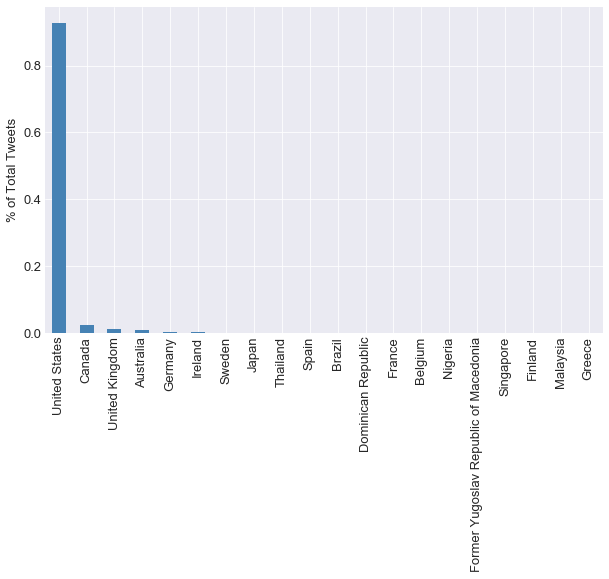

In [132]:
# plot histogram of tweets counts by country of origin
sns.set_style("darkgrid")
x = df.country.value_counts(1).head(20)
x.plot(kind='bar',figsize=(10,6),fontsize=13,color='steelblue')
plt.ylabel('% of Total Tweets', fontsize=13)

- Just like we suspected, an overwhelming majority of tweets originate from the US. Next we will get the state by state counts.

In [133]:
# get latitudes and longitudes

# some helper funtions to get longs and lats
def lats(x):
    return x[1]

def longs(x):
    return x[0]

# --------------------------------------------------------#
# append longs and lats to dframe
df['latitude'] = df['geo_code'].apply(lats)
df['longitude'] = df['geo_code'].apply(longs)
df.columns

Index(['date', 'user_loc', 'message', 'full_name', 'country', 'country_code',
       'geo_code', 'predictions', 'latitude', 'longitude'],
      dtype='object')

In [138]:
# for US tweets extract state abreviations for a new STATE column
# helper function to extract state origin of every tweet
def get_state(x):
    
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

    states_dict = {
            'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa',
            'AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut',
            'DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
            'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois',
            'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
            'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan',
            'MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands',
            'MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
            'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
            'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
            'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island',
            'SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
            'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont',
            'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'
    }


    abv = x.split(',')[-1].lstrip().upper()
    state_name = x.split(',')[0].lstrip()
    if abv in states:
        state = abv
    else:
        if state_name in states_dict.values():
            state = list(states_dict.keys())[list(states_dict.values()).index(state_name)]
        else:
            state = 'Non_USA'    
    return state

# ____________________________________________________________________________

# create abreviated states column
df = df.copy()
df['states'] = df['full_name'].apply(get_state)
list(df['states'].head())

['Non_USA', 'PA', 'FL', 'NY', 'FL']

In [139]:
# save updated dataframe
df.to_pickle('df_paulry_longs_lats.p')

In [2]:
# retrive updated dataframe
df = pd.read_pickle('df_paulry_longs_lats.p')

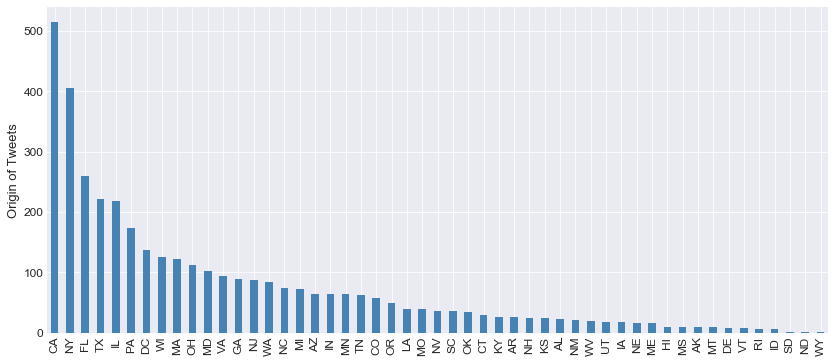

In [3]:
# plot tweets distribution by state

plt.style.use('seaborn-darkgrid')
df_states = df[df.country=='United States']
df_states = df_states[df_states.states!='Non_USA']

x = df_states.states.value_counts()
x.plot(kind='bar',figsize=(14,6),fontsize=12,color='steelblue')
plt.ylabel('Origin of Tweets', fontsize=13)

- As shown above we can see where majority of the tweets are coming from and it looks like it may be correlated to how populous and big the state is.
- Next we extract the total sentiment from each state by adding positives to negatives and the final number is a +/- indicator.
- We will use this total sentiment from each state to create a heat map showng the most negative to the most positive states.

In [4]:
# extract total sentiment per state
df_state_sentiment = df_states.groupby(['states'])['predictions'].value_counts().unstack().fillna(0.0).reset_index()
df_state_sentiment['total_sentiment'] = -(df_state_sentiment[0])+df_state_sentiment[1] 
df_state_sentiment[15:24]

predictions states      0     1  total_sentiment
15           IN     58.0   7.0  -51.0           
16           KS     22.0   2.0  -20.0           
17           KY     19.0   8.0  -11.0           
18           LA     30.0   10.0 -20.0           
19           MA     105.0  17.0 -88.0           
20           MD     83.0   20.0 -63.0           
21           ME     11.0   5.0  -6.0            
22           MI     57.0   15.0 -42.0           
23           MN     53.0   11.0 -42.0

In [25]:
# Create the sentiment by state Heat Map 

colorscale=[
            [0, 'rgb(31,120,180)'], 
            [0.35, 'rgb(166, 206, 227)'], 
            [0.75, 'rgb(251,154,153)'], 
            [1, 'rgb(227,26,28)']
           ]

data = dict(type='choropleth',
            colorscale = colorscale,
            reversescale=True,
            locations = df_state_sentiment['states'],
            z = df_state_sentiment['total_sentiment'],
            locationmode = 'USA-states',
            text = df_state_sentiment['states'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Twitter Sentiment"}
            )

layout = dict(title = 'Twitter Sentiment: GOP House Speaker: Paul Ryan',
              geo = dict(scope='usa'
                        )
             )

choromap_us = go.Figure(data = [data],layout = layout)

# plotly.offline.plot(choromap_us, filename='img_map.html')  # save html map
IFrame('img_map.html', width=950, height=700)  # view saved map html file

- The total sentiment is obtained by summing up the positives and negatives for each state to come up with a final number.
- From the heat map above we can make some interseting observations.
- From the colorscale to the right of the map, the blues transition to reds indicating positive to negative sentiment. The scale does actually start at 0 since no states muster a total sentiment in the positive side. So the more we go in the red, the more negative the sentiment gets.
- New York and California have the most negative sentiment on this keyword search. Keeping in mind that NY and CA have the highest twitter using population which is very likely to skew the image above.
- As such, I feel that this heatmap is not very reliable but it is a good starting point to exploring ***sentiment vs states*** visualizations.
- Next we will see an alternative heat map where we will map every tweet in the dataset from the respective geolocation data.

In [10]:
# use the folium library to create all tweet origins in the dataset on map of US

geoplots = []
for index, row in df_states[['latitude','longitude','predictions']].iterrows():
    geoplots.append([row['latitude'],row['longitude'],row['predictions']])

mus = folium.Map(location=[39, -99], zoom_start=4)
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(mus)

mus.choropleth(
    geo_data='us_states.geojson',
    fill_color='red', 
    fill_opacity=0.1, 
    line_opacity=0.2,
    name='US States')
    
mus.add_child(plugins.HeatMap(geoplots,
                            name='Twitter HeatMap',
                            radius=10,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))
folium.TileLayer('cartodbpositron').add_to(mus)
folium.TileLayer('cartodbdark_matter').add_to(mus)
folium.TileLayer('Mapbox Control Room').add_to(mus)
folium.LayerControl().add_to(mus)
mus.save("twitter_us_map.html") 
IFrame('twitter_us_map.html', width=960, height=520)

# some code to save and display image to png  for all browsers support
# img = plt.imread('twitter_sentiment_crop.png')
# plt.figure(figsize=(18,9))
# plt.imshow(img)

- The above map of the US shows a lot of tweets originate from these high population density areas.
- At best, the map gives us a way to see where the tweets are coming from and the next step would be to map them according to their sentiment value for a better geo representation of sentiment.
- We can also add a time dimension to the map to visualize tweets as they happen in a time series and in real time which would be a great tool for tracking a topic of interest for the parties involved. Such tools have been used before during presidential campaigns and during natural disasters.

### Conclusions

- So far our model has performed relatively well for a sentiment analysis model with an *accuracy of 76%* but a lot can be done to improve our confidence in this perfomance.
- I think it is a good base model whose performance can be improved by experimenting with the suggestions below:
    - Additional data normalization can be performed on the training corpus. We removed stop words from our training data but we can also experiment with [stemming](https://en.wikipedia.org/wiki/Stemming) and [lemmatization]() which are both ways of analyzing words in a corpus based on their root or base word.
    - We could also try out different ways of tokenizing the words with special attention to capitalized words and special characters.
    - Emojis could also be used to extract more context to the text.
    - Experiment with multiclass labels to accomodate all human emotions that can be conveyed through text.
    - Consider other ML algorithims like SVMs, Decision Trees, Neural Nets etc and even ensembles of these algorithims.
    - Finally I wonder if it would be beneficial to train a model on different topics and pick the most relevant one for different datasets. For example, a model for *Law* trained on an extensive library of law documents or a model for *Sports* trained on sports related text like tweets associated with sports and sports personalities. The ground is definetly rich for experimentation and subsequent evaluation of course.




[back to the top](#back_to_the_top_cell)


### Next Steps : Web App

- Next I will build a web application that will utilize the final model to predict sentiment based on user supplied text through a web browser.
- The code for this part of the project will be up shortly at [my Github account](https://github.com/RonKG/machine-learning-portfolio-projects).